**The Battle of Neighborhoods**

**Problem Background**

New York City is one of the most populous cities in the United States. New York City was home to 8,336,817 people in 2019 and making it the most densely populated major city in the United States. It also accounts for over 40% of the population of New York State. With a long history of international immergration, New York City has been described as the cultural, financial, and media capital of the world 

Being described as the cultural capital of the world, New York City's food culture includes an array of international cuisines influenced by the city's immigrant history. There are many resturants in New york City, each beloning to different categories such as Chinese , Italian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Chinese resturants.

**Problem Description**

To surive in the competitive environment of New York City, we must find the best location that may help us get as many customers as possible. We have to know better about the surroundings and find out the place that has best business potential. 

We plan to solve following problems:
* What is best location in New York City for Chinese restaurants?
* Which areas have potential Chinese restaurant market ?
* Which all areas lack Chinese resturants ?
* Which is the best place to stay if I prefer Chinese restaurants ?

**Data**

* Collect the New York data from https://cocl.us/new_york_dataset
* Using FourSquare API to find all venues for each neighborhood.
* Filter out all venues that are Chinese Resturants.
* Find rating , tips and like count for each Chinese Resturants using FourSquare API and sort the data
* Visualize the Ranking of neighborhoods using folium library(python)

**Question to Answer**

* What is best location in New York City for Chinese Restaturants ?
* Which areas have potential Chinese Resturant Market ?
* Which all areas lack Chinese Resturants ?
* Which is the best place to stay if I prefer Chinese food ?

**Analysis**

In [7]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [8]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [9]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'EPMIADFXPEZAHXB41SPFXFIDOJBDFN3CZRZFL4LKRDBWSPCA' # changed my Foursquare ID
    CLIENT_SECRET = 'M1C5WWVFKWEIIX3CVX00R2XX1CJQUYTF3FVFSHEM3W54QJWZ' # changed Foursquare Secret
    VERSION = '20200713' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [10]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'EPMIADFXPEZAHXB41SPFXFIDOJBDFN3CZRZFL4LKRDBWSPCA' # i have changed the id with ##
    CLIENT_SECRET = 'M1C5WWVFKWEIIX3CVX00R2XX1CJQUYTF3FVFSHEM3W54QJWZ' # i have changed the secret with ##
    VERSION = '20200713' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [12]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
new_york_data.shape

(306, 4)

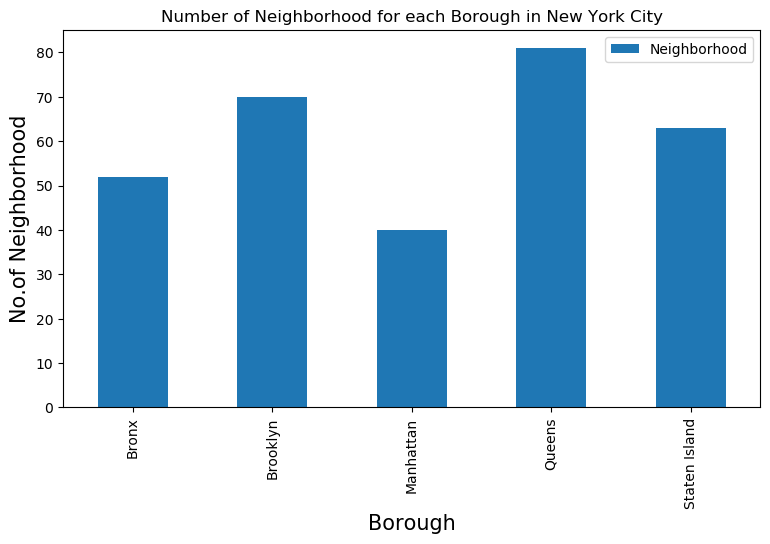

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
asian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    asian_resturants=venues[venues['Category']=='Asian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Asian Resturants in '+Neighborhood+', '+Borough+':'+str(len(asian_resturants)))
    for resturant_detail in asian_resturants.values.tolist():
        id, name , category=resturant_detail
        asian_rest_ny = asian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Asian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Asian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Asian Resturants in Eastchester, Bronx:2
done
( 4 / 306 ) Asian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Asian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Asian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Asian Resturants in Marble Hill, Manhattan:1
done
( 8 / 306 ) Asian Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) Asian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Asian Resturants in Williamsbridge, Bronx:1
done
( 11 / 306 ) Asian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Asian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Asian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Asian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Asian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Asian Resturants in Morris Heights, Bronx:1
done
( 17 / 306 ) Asian Resturants in Fordham, Bronx:0
done

done
( 134 / 306 ) Asian Resturants in Howard Beach, Queens:0
done
( 135 / 306 ) Asian Resturants in Corona, Queens:0
done
( 136 / 306 ) Asian Resturants in Forest Hills, Queens:3
done
( 137 / 306 ) Asian Resturants in Kew Gardens, Queens:1
done
( 138 / 306 ) Asian Resturants in Richmond Hill, Queens:0
done
( 139 / 306 ) Asian Resturants in Flushing, Queens:2
done
( 140 / 306 ) Asian Resturants in Long Island City, Queens:0
done
( 141 / 306 ) Asian Resturants in Sunnyside, Queens:0
done
( 142 / 306 ) Asian Resturants in East Elmhurst, Queens:1
done
( 143 / 306 ) Asian Resturants in Maspeth, Queens:1
done
( 144 / 306 ) Asian Resturants in Ridgewood, Queens:0
done
( 145 / 306 ) Asian Resturants in Glendale, Queens:0
done
( 146 / 306 ) Asian Resturants in Rego Park, Queens:2
done
( 147 / 306 ) Asian Resturants in Woodhaven, Queens:1
done
( 148 / 306 ) Asian Resturants in Ozone Park, Queens:0
done
( 149 / 306 ) Asian Resturants in South Ozone Park, Queens:0
done
( 150 / 306 ) Asian Restura

done
( 263 / 306 ) Asian Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Asian Resturants in Jamaica Hills, Queens:0
done
( 265 / 306 ) Asian Resturants in Utopia, Queens:1
done
( 266 / 306 ) Asian Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Asian Resturants in Astoria Heights, Queens:0
done
( 268 / 306 ) Asian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Asian Resturants in Concourse Village, Bronx:0
done
( 270 / 306 ) Asian Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Asian Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Asian Resturants in Sutton Place, Manhattan:0
done
( 273 / 306 ) Asian Resturants in Hunters Point, Queens:2
done
( 274 / 306 ) Asian Resturants in Turtle Bay, Manhattan:1
done
( 275 / 306 ) Asian Resturants in Tudor City, Manhattan:1
done
( 276 / 306 ) Asian Resturants in Stuyvesant Town, Manhattan:0
done
( 277 / 306 ) Asian Resturants in Flatiron, Manhattan:0
done
( 278 / 306 ) Asian Resturants in Sunnyside Gardens, Queens

In [21]:
asian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,50f9fef3e4b0c2329117b8a8,Yumi Asian Bistro & Hibachi Steak House
1,Bronx,Eastchester,4c0dac537189c928c871d7b6,Jimmy's Best Chinese Restaurant
2,Manhattan,Marble Hill,4edeaa092c5b1dfcb9b07738,Empire19
3,Bronx,Williamsbridge,4bd8f7180115c9b688197680,Good Taste
4,Bronx,Morris Heights,4babfacaf964a5203bdb3ae3,Chop Chop


In [22]:
asian_rest_ny.shape

(100, 4)

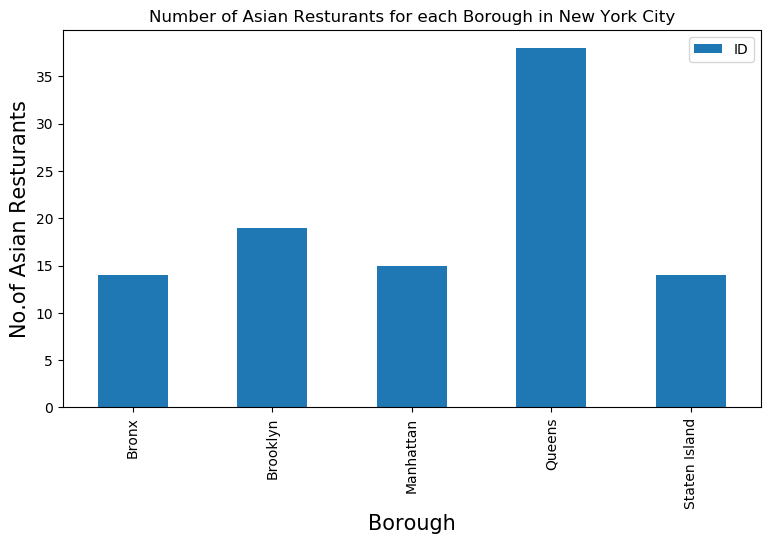

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Asian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Resturants', fontsize=15)
#giving a bar plot
asian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

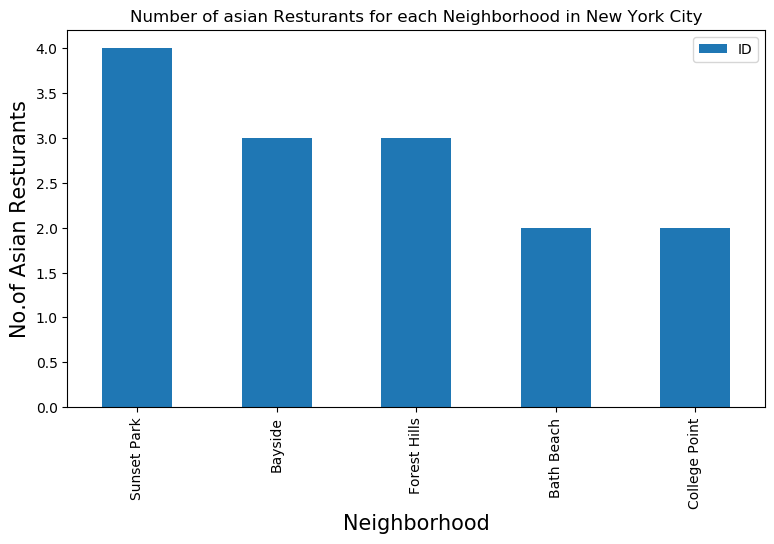

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of asian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Resturants', fontsize=15)
#giving a bar plot
asian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [26]:
asian_rest_ny[asian_rest_ny['Neighborhood']=='Sunset Park']

,Borough,Neighborhood,ID,Name
17,Brooklyn,Sunset Park,4e9cd127722e2953f772740e,Mister Hot Pot 鍋大爺
18,Brooklyn,Sunset Park,51212ff7e4b0841eecdbbcd3,ASEA
19,Brooklyn,Sunset Park,53dc2c0d498e4c49d0105507,Daizen
20,Brooklyn,Sunset Park,4b26da42f964a520ff8124e3,Wong Wong Noodle Soup Inc.


In [27]:
# prepare neighborhood list that contains asian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in asian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(asian_rest_ny),')','processed')
    asian_rest_stats_ny = asian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                                     Name  Likes  \
0  50f9fef3e4b0c2329117b8a8  Yumi Asian Bistro & Hibachi Steak House     41   

   Rating  Tips  
0     7.9    16  
( 1 / 100 ) processed
                         ID                             Name  Likes  Rating  \
0  4c0dac537189c928c871d7b6  Jimmy's Best Chinese Restaurant      7     6.7   

   Tips  
0     4  
( 2 / 100 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edeaa092c5b1dfcb9b07738
( 3 / 100 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd8f7180115c9b688197680
( 4 / 100 ) processed
                         ID       Name  Likes  Rating  Tips
0  4babfacaf964a5203bdb3ae3  Chop Chop      8     7.0     9
( 5 / 100 ) processed
                         ID    Name  Likes  Rating  Tips
0  4f9de99ae4b08ea03a934ce3  Ceetay     55     7.8    33
( 6 / 100 ) processed
                        

KeyError: 'venue'

In [28]:
asian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,50f9fef3e4b0c2329117b8a8,Yumi Asian Bistro & Hibachi Steak House,41,7.9,16
1,Bronx,Eastchester,4c0dac537189c928c871d7b6,Jimmy's Best Chinese Restaurant,7,6.7,4
2,Manhattan,Marble Hill,0,0,0,0.0,0
3,Bronx,Williamsbridge,0,0,0,0.0,0
4,Bronx,Morris Heights,4babfacaf964a5203bdb3ae3,Chop Chop,8,7.0,9


In [29]:
asian_rest_stats_ny.shape

(50, 7)

In [30]:
asian_rest_ny.shape

(100, 4)

In [31]:
asian_rest_stats_ny.to_csv('asian_rest_stats_ny.csv', index=False)

In [32]:
asian_rest_stats_ny_csv=pd.read_csv('asian_rest_stats_ny.csv')
asian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,50f9fef3e4b0c2329117b8a8,Yumi Asian Bistro & Hibachi Steak House,41,7.9,16
1,Bronx,Eastchester,4c0dac537189c928c871d7b6,Jimmy's Best Chinese Restaurant,7,6.7,4
2,Manhattan,Marble Hill,0,0,0,0.0,0
3,Bronx,Williamsbridge,0,0,0,0.0,0
4,Bronx,Morris Heights,4babfacaf964a5203bdb3ae3,Chop Chop,8,7.0,9


In [33]:
asian_rest_stats_ny['Likes']=asian_rest_stats_ny['Likes'].astype('float64')

In [34]:
asian_rest_stats_ny['Tips']=asian_rest_stats_ny['Tips'].astype('float64')

In [35]:
asian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [36]:
asian_rest_stats_ny.iloc[asian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              4acca438f964a5201dc920e3
Name                   Momofuku Ssäm Bar
Likes                               1518
Rating                                 9
Tips                                 525
Name: 35, dtype: object

In [37]:
asian_rest_stats_ny.iloc[asian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              591b9e948496ca6e22cdd3f6
Name                        Ramen Ishida
Likes                                 74
Rating                               9.1
Tips                                  21
Name: 36, dtype: object

In [38]:
asian_rest_stats_ny.iloc[asian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              4acca438f964a5201dc920e3
Name                   Momofuku Ssäm Bar
Likes                               1518
Rating                                 9
Tips                                 525
Name: 35, dtype: object

In [39]:
ny_neighborhood_stats=asian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [40]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
18,Gramercy,9.00
21,Lower East Side,8.95
11,East Village,8.90
3,Brighton Beach,8.90
33,Tribeca,8.70
5,Bushwick,8.70
6,Chinatown,8.60
29,Prospect Park South,8.50
19,Jackson Heights,8.40
14,Elmhurst,8.25


In [41]:
ny_borough_stats=asian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [42]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.720000
1,Brooklyn,6.568750
0,Bronx,6.357143
3,Queens,6.290000


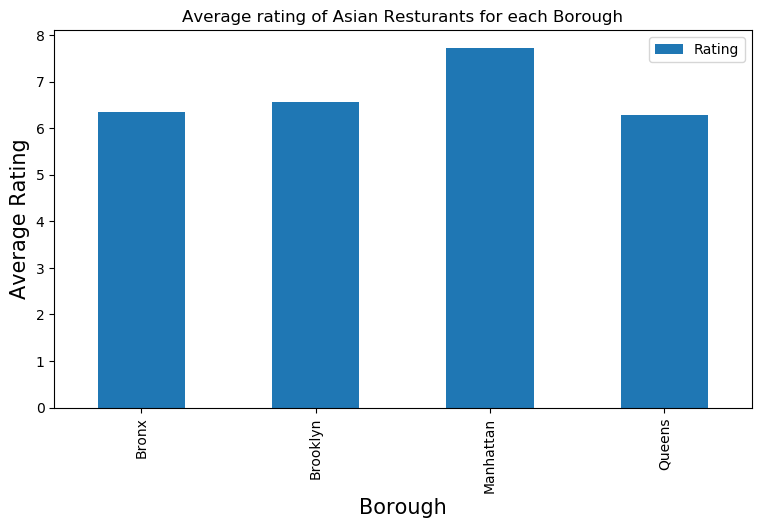

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Asian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
asian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [46]:
ny_neighborhood_stats

,Neighborhood,Average Rating
18,Gramercy,9.0


**Conclusion**

*Queen has most Asian restaurants among all Borough in Newyork
*Average rating of Asian restaurants in Manhattan is the highest
*Sunset Park has most Asian restaurants
